# MNIST- handwritten digit recognition
[The MNIST problem](http://yann.lecun.com/exdb/mnist/) is a dataset developed by Yann LeCun, Corinna Cortes and Christopher
Burges for evaluating machine learning models on the handwritten digit classification problem.
The dataset was constructed from a number of scanned document datasets available from the
National Institute of Standards and Technology (NIST). This is where the name for the dataset
comes from, as the Modified NIST or MNIST dataset.
Images of digits were taken from a variety of scanned documents, normalized in size and
centered. This makes it an excellent dataset for evaluating models, allowing the developer to
focus on the machine learning with very little data cleaning or preparation required. Each
image is a 28 × 28 pixel square (784 pixels total).
The dataset below has 60000 images for training and 10000 for testing. Labels are the 10 digits (0-9), therefore it is a multi-class classification problem. Excellent results achieve a prediction error of less than 1%. State-of-the-art prediction
error of approximately 0.2% can be achieved with large Convolutional Neural Networks.

## Loading Data & EDA

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


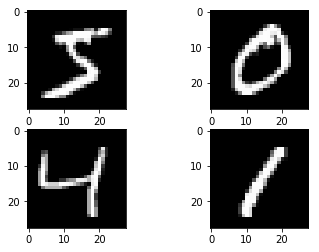

In [13]:
# fix random seed for reproducibility
seed = 123
np.random.seed(seed)
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap='gray')
plt.subplot(222)
plt.imshow(X_train[1], cmap='gray') 
plt.subplot(223)
plt.imshow(X_train[2], cmap='gray')
plt.subplot(224)
plt.imshow(X_train[3], cmap='gray')
# show the plot
plt.show()

In [14]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train.max(), X_train.min()) # Note that the pixel value scales 0-255 

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
255 0


## Baseline model using simple neural net
MNIST problem is not terribly difficult that we may get a decent result by using simple neural nets without CNN. We can build a baseline model with a simple neural net and later compare how a CNN model does better that the baseline.

A simple NN talkes 1D input, so we will change the data shape to a 1D vector called "one-hot encode": a 2D image of 28x28 pixels is reshaped (flattened) to a 1D vector of 784 pixels. Then the pixel values are normalized so that a value is between 0 and 1. Then we make labels (both y_train and y_test) to categorical- which means we make 10 columns with values 0 or 1 instead of 1 column with values 0-9.     


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

In [3]:
# fix random seed for reproducibility
seed = 123
np.random.seed(seed)
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, init= 'normal' , activation= 'relu'))
    model.add(Dense(num_classes, init= 'normal' , activation= 'softmax'))
    # Compile model
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200,
verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
4s - loss: 0.2836 - acc: 0.9194 - val_loss: 0.1350 - val_acc: 0.9607
Epoch 2/10
1s - loss: 0.1115 - acc: 0.9679 - val_loss: 0.1028 - val_acc: 0.9672
Epoch 3/10
1s - loss: 0.0722 - acc: 0.9786 - val_loss: 0.0773 - val_acc: 0.9760
Epoch 4/10
1s - loss: 0.0506 - acc: 0.9856 - val_loss: 0.0686 - val_acc: 0.9791
Epoch 5/10
1s - loss: 0.0368 - acc: 0.9895 - val_loss: 0.0635 - val_acc: 0.9808
Epoch 6/10
1s - loss: 0.0272 - acc: 0.9928 - val_loss: 0.0589 - val_acc: 0.9815
Epoch 7/10
1s - loss: 0.0190 - acc: 0.9953 - val_loss: 0.0658 - val_acc: 0.9791
Epoch 8/10
1s - loss: 0.0139 - acc: 0.9972 - val_loss: 0.0599 - val_acc: 0.9811
Epoch 9/10
1s - loss: 0.0100 - acc: 0.9981 - val_loss: 0.0596 - val_acc: 0.9823
Epoch 10/10
1s - loss: 0.0074 - acc: 0.9987 - val_loss: 0.0642 - val_acc: 0.9798
Baseline Error: 2.02%


### The model baseline_model() line-by-line explanation
`model = Sequential()`     
Instantiates a model object from `Sequential` class. A model from Sequential() makes a stack of layers in series, and is the easist way to get started with building a model using Keras. For more information about Sequrntial models, see the [documentation](https://keras.io/getting-started/sequential-model-guide/). If you want to build a model that is not sequential but has branches, you need to use the [functional API](https://keras.io/getting-started/functional-api-guide/).  

`model.add(...)`    
A sequential model can add the next layer by using the method `.add()`, here we added two `Dense` layers.

[`Dense()`](https://keras.io/layers/core/#dense)     
A fully-connected (FC) layer. For example, Dense(10) gives a fully connected layer with 10 neurons in it. As an option, you can also specify activation function (in our case 'relu'), weights initialization method (using 'normal' - normal distribution. You can get rid of initialization specified in the `Dense()` layer and alternatively add to the `model` later right after the `Dense()` layer (example below). 
```
model.add(Dense(...))
model.add(Activation('relu')
```
**Note** The code above is based on Keras version 1.2.1. Keras command changed quite a lot when moving to version 2.0. For example, `init` option in `Dense()` has been changed to `kernel_initializer`, and `nb_epoch` in `model.fit()` to `epochs`. If you run 1.2 codes in 2.0 kernel, it will still work with some warning.

`model.complie()`    
Compiles the model. You can specify the loss and optimizer ([see more](https://keras.io/models/sequential/)). For more control on the optimizer, you can use [`optimizers` library](https://keras.io/optimizers/) (see an example below).

```
from keras import optimizers

model = Sequential()
model.add(Dense(64, init='uniform', input_shape=(10,)))
model.add(Activation('tanh'))
model.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)
```

The option `metric` prints out the specified metric (in our case accuracy) for the training and the validation data during the training.

`model.fit()`  
Runs the training. Takes training data and optinal validation data. [see more](https://keras.io/models/sequential/)
```
fit(self, x, y, batch_size=32, epochs=10, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0)
```

## Simple CNN model
Now we will build a simple CNN model and see if it can do better than our baseline model above (NN without convolution layer).

In [4]:
# Simple CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

K.set_image_dim_ordering('tf')
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# define a simple CNN model
def simple_cnn_model():
    # create model
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, input_shape=(28, 28, 1), activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation= 'relu'))
    model.add(Dense(num_classes, activation= 'softmax'))
    # Compile model
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model
# build the model
model = simple_cnn_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200,
verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s - loss: 0.2544 - acc: 0.9269 - val_loss: 0.0907 - val_acc: 0.9734

### Line-by-line explanation of simple_cnn_model()
In the above we built a single convolution layer CNN model.

**Note** In the first part after importing libraries, we set the `dim_ordering` to 'tf'. It means we use Tensorflow convention when we input data. Keras used to be working with Theano, but now the default backend for Keras is Tensorflow. Unless you changed the Keras configuration to Theano it will use Tensorflow. If you use Theano convention (`dim_ordering='th'`), then you have to change 28,28,1 (w x h x c) to 1,28,28 (c x w x h) in the above code.

After loading the data, we change the array shape of the data such that it becomes num_samples x width x height x channel.

Next, we normalize the data so that pixel values are between 0 and 1, then change the labels shape to categorical (10 columns in this case).

In the `simple_cnn_model()`, we build a single conv-layer model again using Sequrntial(). The convolution2d layer has 32 5x5 filters and has relu activation. Then we add 2x2 max pooling layer, a dropout layer (20% to be dropped), and 128-unit dense layer with relu activation and an output layer (a dense with 10 labels and softmax activation). Using `softmax` activation is typical for classification output.

In the `model.compile()`, we again set loss function as `categorical_crossentropy` which is typical good choice for a classification problem. [Adam optimizer](https://arxiv.org/abs/1412.6980v8) is a good choice since it has smart learning-rate control built in. The default learning rate value is 0.001.


## Two-layer CNN model
The model below has 2 convolutional layers and two dense layers before the output layer. It also has a dropout layer. It results the error rate around 0.8%

In [38]:
# Two-layer-CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

K.set_image_dim_ordering( 'tf' )

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channel]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype( 'float32' )
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype( 'float32' )
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
# define the larger model
def bilayer_model():
    # create model
    model = Sequential()
    model.add(Convolution2D(30, 5, 5, input_shape=(28, 28, 1), activation= 'relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(15, 3, 3, activation= 'relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation= 'relu' ))
    model.add(Dense(50, activation= 'relu' ))
    model.add(Dense(num_classes, activation= 'softmax' ))
    # Compile model
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model
# build the model
model = bilayer_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200,
verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
4s - loss: 0.3748 - acc: 0.8849 - val_loss: 0.0858 - val_acc: 0.9739
Epoch 2/10
3s - loss: 0.0979 - acc: 0.9704 - val_loss: 0.0571 - val_acc: 0.9807
Epoch 3/10
3s - loss: 0.0721 - acc: 0.9777 - val_loss: 0.0418 - val_acc: 0.9868
Epoch 4/10
3s - loss: 0.0590 - acc: 0.9815 - val_loss: 0.0327 - val_acc: 0.9897
Epoch 5/10
3s - loss: 0.0493 - acc: 0.9847 - val_loss: 0.0307 - val_acc: 0.9898
Epoch 6/10
3s - loss: 0.0428 - acc: 0.9869 - val_loss: 0.0367 - val_acc: 0.9886
Epoch 7/10
2s - loss: 0.0404 - acc: 0.9873 - val_loss: 0.0275 - val_acc: 0.9917
Epoch 8/10
3s - loss: 0.0364 - acc: 0.9886 - val_loss: 0.0297 - val_acc: 0.9907
Epoch 9/10
3s - loss: 0.0342 - acc: 0.9889 - val_loss: 0.0247 - val_acc: 0.9918
Epoch 10/10
3s - loss: 0.0304 - acc: 0.9901 - val_loss: 0.0259 - val_acc: 0.9918
Large CNN Error: 0.82%


## More convolution layers 
Below model is somewhat similar to the model above. It is based on the heuristics ([see more](http://cs231n.github.io/convolutional-networks/), especially the ConvNet Architecture section) from VGG-net like models. It also applied stronger and more dropouts and longer epoch to reduce overfitting. It results approximately 0.6% error rate.

In [40]:
# More convolution layers
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

K.set_image_dim_ordering( 'tf' )

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channel]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype( 'float32' )
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype( 'float32' )
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
def multilayer_cnn_model():
    # create model
    model = Sequential()
    model.add(Convolution2D(16, 3, 3, input_shape=(28, 28, 1), activation= 'relu', border_mode='same'))
    model.add(Convolution2D(16, 3, 3, activation= 'relu', border_mode='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32, 3, 3, activation= 'relu', border_mode='same'))
    model.add(Convolution2D(32, 3, 3, activation= 'relu', border_mode='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation= 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation= 'relu'))
    model.add(Dense(num_classes, activation= 'softmax'))
    # Compile model
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model
# build the model
model = multilayer_cnn_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=15, batch_size=200,
verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
4s - loss: 0.4295 - acc: 0.8574 - val_loss: 0.0684 - val_acc: 0.9784
Epoch 2/15
3s - loss: 0.1235 - acc: 0.9627 - val_loss: 0.0434 - val_acc: 0.9853
Epoch 3/15
3s - loss: 0.0904 - acc: 0.9719 - val_loss: 0.0336 - val_acc: 0.9885
Epoch 4/15
3s - loss: 0.0771 - acc: 0.9771 - val_loss: 0.0301 - val_acc: 0.9904
Epoch 5/15
3s - loss: 0.0655 - acc: 0.9809 - val_loss: 0.0311 - val_acc: 0.9893
Epoch 6/15
3s - loss: 0.0577 - acc: 0.9827 - val_loss: 0.0238 - val_acc: 0.9915
Epoch 7/15
3s - loss: 0.0512 - acc: 0.9844 - val_loss: 0.0221 - val_acc: 0.9926
Epoch 8/15
3s - loss: 0.0485 - acc: 0.9850 - val_loss: 0.0224 - val_acc: 0.9930
Epoch 9/15
3s - loss: 0.0463 - acc: 0.9859 - val_loss: 0.0179 - val_acc: 0.9941
Epoch 10/15
3s - loss: 0.0423 - acc: 0.9874 - val_loss: 0.0193 - val_acc: 0.9935
Epoch 11/15
3s - loss: 0.0408 - acc: 0.9871 - val_loss: 0.0178 - val_acc: 0.9947
Epoch 12/15
3s - loss: 0.0394 - acc: 0.9884 - val_loss: 0.0171 - val

## Next steps
Now you know how to build a simple multilayer convolutional neural network model. Try change hyperparameters such as epoch, batch size for training, number of filters, filter size, stride, border mode, even actiation in the convolution layer, number of neurons in dense layer, dropout rates. Try chaning the network structure by adding or removing dropout layers or maxpooling layers, or adding more dense layer or convolution layers. Try customize Adam optimizer using the `optimizer` library and try changing learning rate.
Try different optimizer such as SGD. There are far too many numbers of combinations and oftentimes it's not efficient to random guess hyper parameter values. Consult with tips and heuristics online and resource like [Stanford CS231n](http://cs231n.github.io/convolutional-networks/). 
The state of the art result is an error rate of 0.2%. It is harder and harder to improve performance as you get closer to the state of the art. See if you can get below 0.5% and congratulate yourself.